Tải bộ dữ liệu WELFake

In [6]:
!gdown 1CgDGe1t2_SUVw9VvzOpMeRNfIvdHsjY3

Downloading...
From (original): https://drive.google.com/uc?id=1CgDGe1t2_SUVw9VvzOpMeRNfIvdHsjY3
From (redirected): https://drive.google.com/uc?id=1CgDGe1t2_SUVw9VvzOpMeRNfIvdHsjY3&confirm=t&uuid=b9423890-33d6-463a-948e-c5861be33f21
To: /content/WELFake_Dataset.csv
100% 245M/245M [00:04<00:00, 53.0MB/s]


In [7]:
import re
import nltk
import tensorflow
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from tensorflow.keras.layers import Embedding, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split

Xóa các kí tự null và nối cột title vào cột test

In [8]:
df = pd.read_csv("/content/WELFake_Dataset.csv")
df.dropna(subset = ['text', 'title'], inplace = True)
df['text'] = df['title'] + ' ' + df['text']

In [9]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

Thực hiện tăng cường dữ liệu xóa các từ không cần thiết (FWD)

In [10]:
import re
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

stemmer = PorterStemmer()
corpus = []

def replace_synonyms(text):
    words = word_tokenize(text)
    replaced_text = []

    for word in words:
        synonyms = wordnet.synsets(word)
        if synonyms:
            synonym = synonyms[0].lemmas()[0].name()
            replaced_text.append(synonym.replace('_', ' '))
        else:
            replaced_text.append(word)

    return ' '.join(replaced_text)

def remove_function_words(text):
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text)
    filtered_text = [word for word in words if word.lower() not in stop_words]

    return ' '.join(filtered_text)

def preprocess_txt(text, use_synonyms=False, use_fwd=False):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    if use_synonyms:
        text = replace_synonyms(text)

    if use_fwd:
        text = remove_function_words(text)

    tokens = word_tokenize(text)

    # Stemming
    tokens = [stemmer.stem(token) for token in tokens]
    unique_tokens = []
    for token in tokens:
        if token not in unique_tokens:
            unique_tokens.append(token)

    preprocessed_text = ' '.join(unique_tokens)
    corpus.append(preprocessed_text)
    return preprocessed_text

df['preprocessed_text'] = df['text'].apply(lambda x: preprocess_txt(x, use_synonyms=False, use_fwd=True) if isinstance(x, str) else "")

In [11]:
df.head()

,Unnamed: 0,title,text,label,preprocessed_text
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,1,law enforc high alert follow threat cop white ...
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,1,unbeliev obama attorney gener say charlott rio...
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...","Bobby Jindal, raised Hindu, uses story of Chri...",0,bobbi jindal rais hindu use stori christian co...
4,4,SATAN 2: Russia unvelis an image of its terrif...,SATAN 2: Russia unvelis an image of its terrif...,1,satan russia unv imag terrifi new supernuk wes...
5,5,About Time! Christian Group Sues Amazon and SP...,About Time! Christian Group Sues Amazon and SP...,1,time christian group sue amazon splc design ha...


Thực hiện one-hot encoding

In [12]:
vocab_size = 10000

onehot=[one_hot(words,vocab_size)for words in corpus]

In [13]:
sent_length = 500
padded_onehot = pad_sequences(onehot, padding='post',maxlen=sent_length)
print(padded_onehot)

[[6155 2755 8627 ...    0    0    0]
 [3688 5620 3088 ...    0    0    0]
 [3390 8375 2767 ...    0    0    0]
 ...
 [3807 7823 7739 ...    0    0    0]
 [3768 5092 8393 ...    0    0    0]
 [8662 9224 8570 ...    0    0    0]]


In [14]:
padded_data = np.array(padded_onehot)
label = np.array(df['label'])

print(padded_data.shape)
print(label.shape)

(71537, 500)
(71537,)


In [15]:
X_train, X_test, y_train, y_test = train_test_split(padded_onehot, label, test_size=0.2, random_state=42)
print(f"training data shape {X_train.shape}")
print(f"testing data shape {X_test.shape}")

training data shape (57229, 500)
testing data shape (14308, 500)


Xây dựng mô hình 

In [16]:
embedding_vector_features=40
model=Sequential()
model.add(Embedding(vocab_size,embedding_vector_features,input_length=sent_length))
model.add(LSTM(100, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


Huấn luyện mô hình 

In [17]:
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_train, y_train),
    epochs=10,
    batch_size=64
)

Epoch 1/10
895/895 ━━━━━━━━━━━━━━━━━━━━ 37s 31ms/step - accuracy: 0.5055 - loss: 0.6941 - val_accuracy: 0.5117 - val_loss: 0.6917
Epoch 2/10
895/895 ━━━━━━━━━━━━━━━━━━━━ 28s 31ms/step - accuracy: 0.5054 - loss: 0.6992 - val_accuracy: 0.5125 - val_loss: 0.6885
Epoch 3/10
895/895 ━━━━━━━━━━━━━━━━━━━━ 28s 31ms/step - accuracy: 0.5123 - loss: 0.6883 - val_accuracy: 0.5231 - val_loss: 0.6838
Epoch 4/10
895/895 ━━━━━━━━━━━━━━━━━━━━ 28s 31ms/step - accuracy: 0.5226 - loss: 0.6811 - val_accuracy: 0.5073 - val_loss: 0.6719
Epoch 5/10
895/895 ━━━━━━━━━━━━━━━━━━━━ 41s 32ms/step - accuracy: 0.5214 - loss: 0.6800 - val_accuracy: 0.5077 - val_loss: 0.6769
Epoch 6/10
895/895 ━━━━━━━━━━━━━━━━━━━━ 41s 32ms/step - accuracy: 0.5203 - loss: 0.6762 - val_accuracy: 0.5287 - val_loss: 0.6698
Epoch 7/10
895/895 ━━━━━━━━━━━━━━━━━━━━ 41s 32ms/step - accuracy: 0.5267 - loss: 0.6693 - val_accuracy: 0.5292 - val_loss: 0.6682
Epoch 8/10
895/895 ━━━━━━━━━━━━━━━━━━━━ 42s 33ms/step - accuracy: 0.5287 - loss: 0.6670 - 

Vẽ đồ thị học accuracy và loss

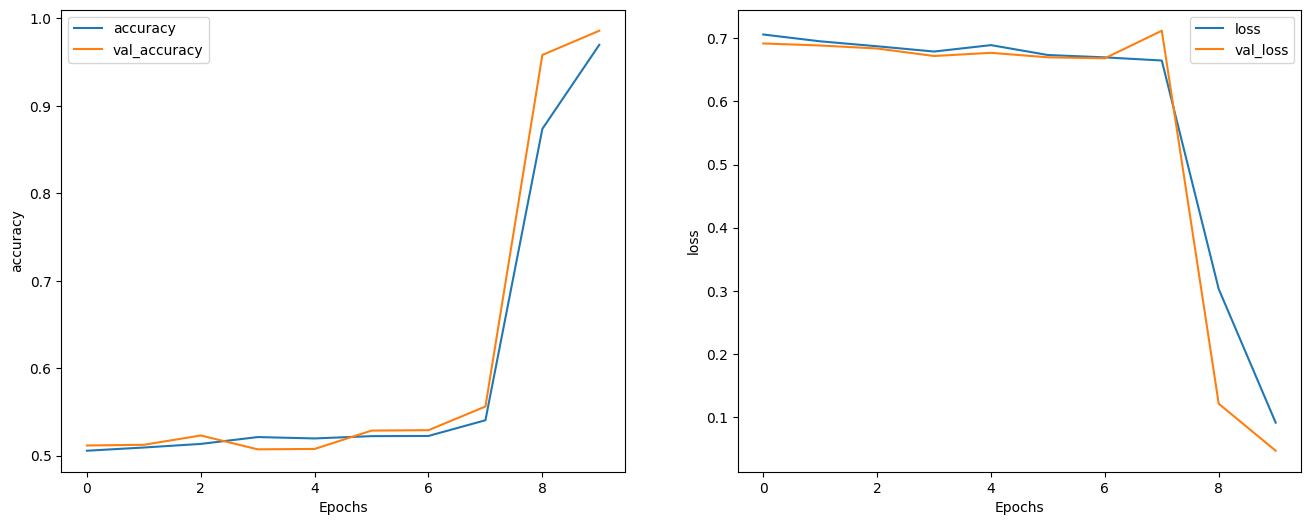

In [18]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):

    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])


plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

Đánh giá mô hình

In [19]:
from sklearn.metrics import accuracy_score, confusion_matrix

y_pred = model.predict(X_test)
y_pred = np.where(y_pred > 0.6, 1, 0)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

448/448 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
Accuracy: 0.9709952474140341


In [20]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      7081
           1       0.97      0.97      0.97      7227

    accuracy                           0.97     14308
   macro avg       0.97      0.97      0.97     14308
weighted avg       0.97      0.97      0.97     14308



Vẽ ma trận nhầm lẫn 

Text(70.72222222222221, 0.5, 'Real Labels')

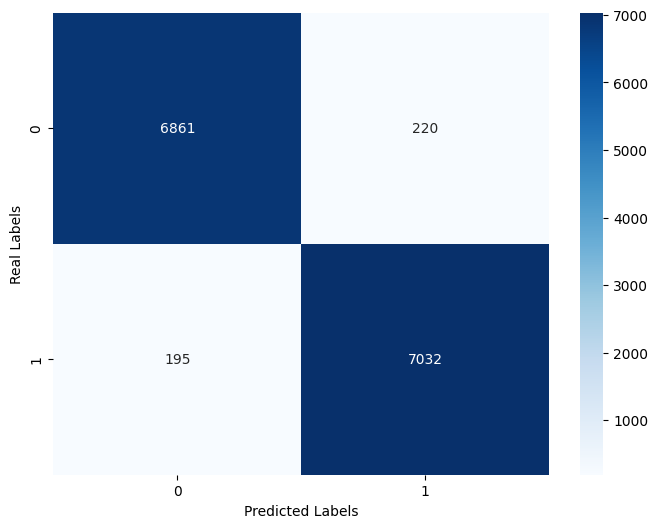

In [21]:
import seaborn as sns

plt.figure(figsize = (8,6))
sns.heatmap(confusion_matrix(y_test,y_pred), annot=True,
            fmt='', cmap='Blues')

plt.xlabel('Predicted Labels')
plt.ylabel('Real Labels')

In [22]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

conf_matrix = confusion_matrix(y_test,y_pred)

true_negatives = conf_matrix[0][0]
false_positives = conf_matrix[0][1]
false_negatives = conf_matrix[1][0]
true_positives = conf_matrix[1][1]

precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
f1 = 2 * (precision * recall) / (precision + recall)
accuracy = (true_positives + true_negatives) / (true_positives + true_negatives + false_positives + false_negatives)

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')
print(f'Accuracy: {accuracy:.4f}')

Precision: 0.9697
Recall: 0.9730
F1-score: 0.9713
Accuracy: 0.9710
